# Markov Chains
## Simulating a coin toss
This first experiment is a simulation of tossing a coin and getting heads twice in a row. We assume that the coin is fair and $p_{head} = \frac{1}{2}$. The three states of the chain are (first head), (second head), (two heads in a row (final state)).

In [353]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [354]:
G_coin = nx.DiGraph()
G_coin.add_nodes_from([0,1,2]) # 0 <- n-th flip | 1 <- (n+1)-th flip | 2 <- end state
p_head = 0.5
p_tail = 1 - p_head
probabilities_coinflip = [(0,1,p_head), (0,0,p_tail), (1,0,p_tail), (1,2,p_head), (2,2,1)]
G_coin.add_weighted_edges_from(probabilities_coinflip)

{(0, 1): Text(0.0, -0.3333333333333333, '0.5'),
 (0, 0): Text(-1.0, -0.3333333333333333, '0.5'),
 (1, 0): Text(0.0, -0.3333333333333333, '0.5'),
 (1, 2): Text(0.5, 0.1666666666666667, '0.5'),
 (2, 2): Text(0.0, 0.6666666666666667, '1')}

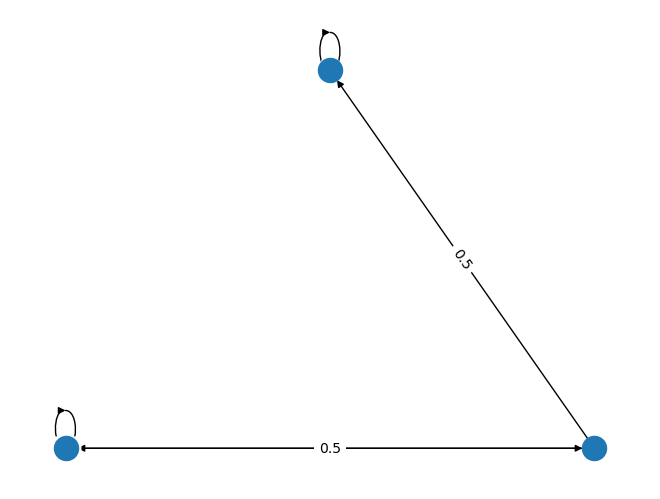

In [355]:
pos=nx.planar_layout(G_coin)
nx.draw(G_coin,pos)
labels = nx.get_edge_attributes(G_coin,'weight')
nx.draw_networkx_edge_labels(G_coin,pos,edge_labels=labels)

In [356]:
G_coin_mat = nx.to_numpy_array(G_coin)
print(G_coin_mat)

[[0.5 0.5 0. ]
 [0.5 0.  0.5]
 [0.  0.  1. ]]


Let $P$ be the adjacency matrix and $v_0$ the initial state (column) vector, the probability to reach each state after $n$ coin tosses is given by $v_n = v_0^t P^n$.

In [357]:
def simulate_n(P, p_vector, n):
    return p_vector @ np.linalg.matrix_power(P,n)

For example the probability of eventually getting two heads in a row after four tosses is $\frac{1}{2}$.

In [358]:
p_coin_initial = np.array([1,0,0])
p_coin_sim_n = simulate_n(G_coin_mat, p_coin_initial, 4)
print(p_coin_sim_n, np.sum(p_coin_sim_n))

[0.3125 0.1875 0.5   ] 1.0


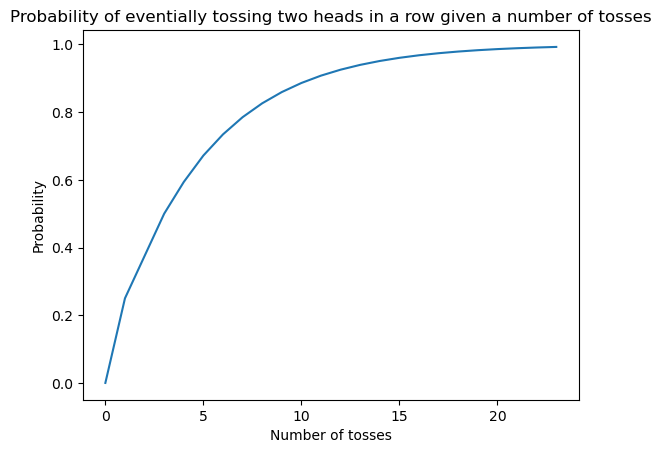

In [359]:
n = 25
p_two_heads = np.empty(n)
for i in range(0,n):
    p_two_heads[i] = simulate_n(G_coin_mat, p_coin_initial,i)[2]

plt.title("Probability of eventially tossing two heads in a row given a number of tosses")
plt.xlabel("Number of tosses")
plt.ylabel("Probability")
plt.plot(p_two_heads[1:]);

The state of equilibrium shown in the plot avobe when $n \rightarrow \infty$ coincides with the eigenvector of $P^t$ asssociated to the eigenvalue of 1. This is reasobale because it means that the eigenvector is $v_0$ such that $v_0^t P^n = v_0$.

In [387]:
eig_val, eig_vector = np.linalg.eig(G_coin_mat.T)
print("Eigenvalues: ", eig_val, "Eigenvector associated to 1", eig_vector[:,0])

Eigenvalues:  [ 1.         -0.30901699  0.80901699] Eigenvector associated to 1 [0. 0. 1.]


## Estimating sequences of words

The second (and frankly more interesting) experiment consists of constructing a Markov Chain in a weighted directed graph where each edge $(u,v,w)$ represents the probability that word $u$ will be followed by word $v$ in the text used to contruct the model. Using this I will try to generate word sequences and try to predict, given a particular word, what other word will follow it. The end of sentences is accointed for. Given "...end. Begin..." an edge $(end,begin,w)$ will not be created.

De dataset for this experiment is parsed from "Crime and Punishemt" and "Brothers Karamazov" both novels by Fyodor Dostoevsky downloaded from the Gutenberg Proyect.

In [360]:
raw_text = np.genfromtxt('data/crimeAndPunishment.txt',dtype='str')
np.append(raw_text, np.genfromtxt('data/brothersKaramazov.txt',dtype='str'))

G_text = nx.DiGraph()
G_text.add_nodes_from(raw_text)
for i in range(0,raw_text.shape[0]-1):
    if raw_text[i+1] == '.':
        i += 2
        continue
    if G_text.has_edge(raw_text[i], raw_text[i+1]):
        G_text[raw_text[i]][raw_text[i+1]]['weight'] += 1.0
    else:
        G_text.add_edge(raw_text[i], raw_text[i+1], weight=1.0)
# at this stage each edge represents how many times word1 was followed by word2 in the source text

for parent_node in G_text.nodes():
    appars_count = 0.0
    for child_node in G_text.neighbors(parent_node):
        appars_count += G_text[parent_node][child_node]['weight']
    for child_node in G_text.neighbors(parent_node):
        G_text[parent_node][child_node]['weight'] /= appars_count
# by dividing each edge u -> v by the sum of all edges adjacent to u we get a proper probability distribution :)
node_array = np.unique(raw_text)
assert(node_array.shape[0] == G_text.number_of_nodes())

In [361]:
distribution_for_node = {}
for node in G_text.nodes():
    node_distribution = []
    neighbors = G_text.neighbors(node)
    for neighbor in neighbors:
        node_distribution.append(G_text[node][neighbor]['weight'])
    distribution_for_node[node] = node_distribution

neighbors_for_node = {}
for node in G_text.nodes():
    neighbor_list = list(G_text.neighbors(node))
    neighbors_for_node[node] = neighbor_list

I will try two approaches for generating word sequences:
- Traverse the graph starting from a node and choosing one of it's neighbors randomly using the probaility distribution generated from the text.
- Traverse the graph starting from a node and choosing one of it's neighbors randomly using a uniform distribution.

The weighted random walk function should produce better results.

In [362]:
def weighted_random_walk(start_node, steps):
    res = []
    prev_node = None
    for i in range(0,steps):
        res.append(start_node)
        if len(neighbors_for_node[start_node]) == 0: # just in case the function hits a dead end (it can happen with a very infrequently used word)
            start_node = prev_node
            continue
        prev_node = start_node
        start_node = np.random.choice(neighbors_for_node[start_node], 1, p=distribution_for_node[start_node])[0]
    return res

def unweighted_random_walk(start_node, steps):
    res = []
    prev_node = None
    for i in range(0,steps):
        res.append(start_node)
        if len(neighbors_for_node[start_node]) == 0: # just in case the function hits a dead end (it can happen with a very infrequently used word)
            start_node = prev_node
            continue
        prev_node = start_node
        start_node = np.random.choice(neighbors_for_node[start_node], 1)[0]
    return res

This function returns a sorted (be edge weight) list of neighbors given a particular node. The reasoning behind this is to predict what word will follow a given one by looking at the weight of it's neighboring edges. The heavier ones correlate with a higher probabity of having those two consecutive words in the text.

In [363]:
def weighted_neighbors(node):
    weights = distribution_for_node[node]
    order = np.argsort(weights)[::-1]
    neighbors = neighbors_for_node[node]
    return [(neighbors[i], weights[i]) for i in order]

Choosing a starting word at random the two traversal strategies can be compared. The weighted walk produces slightly better results, this is reasonable considering it's taking into account not only the apparition of one word after the other in the data, but also the frequency of these apparitions.

In [372]:
random_node = np.random.choice(node_array, 1)[0]
print("Weighted walk:", weighted_random_walk(random_node, 15))
print("Unweighted walk:", unweighted_random_walk(random_node, 15))

Weighted walk: ['homage', 'of', 'them', 'because', 'i', 'dont', 'want', 'to', 'see', 'that', 'we', 'are', 'you', 'it', 'cried']
Unweighted walk: ['homage', 'here', 'near', 'i', 'cursed', 'life', 'what', 'sort', 'shall', 'call', 'an', 'end', 'with', 'two', 'are']


The same can be said when choosing a specific staring word.

In [368]:
print("Weighted walk:", weighted_random_walk('and', 20))
print("Unweighted walk:", unweighted_random_walk('and', 20))

Weighted walk: ['and', 'my', 'excuses', 'to', 'be', 'comforted', 'went', 'down', 'a', 'fashion', 'and', 'dirty', 'by', 'commonplace', 'simpleton', 'at', 'him', 'began', 'to', 'the']
Unweighted walk: ['and', 'ceased', 'when', 'sonia', 'get', 'wiser', 'it', 'amount', 'of', 'malignance', 'laughed', 'they', 'lay', 'for', 'pyotr', 'petrovitchs', 'being', 'that', 'conversation', 'cest']


More intersingly, given a particular word this graph representation makes it easy to estimate what word will follow it and with what probability. Note that this estimation is limited to the word sequences in the source data.

In [373]:
weighted_neighbors('on')[:15]

[('the', 0.34022824536376606),
 ('his', 0.08487874465049929),
 ('a', 0.05206847360912981),
 ('my', 0.029957203994293864),
 ('her', 0.029957203994293864),
 ('to', 0.024964336661911554),
 ('your', 0.020684736091298145),
 ('purpose', 0.016405135520684736),
 ('that', 0.016405135520684736),
 ('it', 0.014978601997146932),
 ('all', 0.012838801711840228),
 ('him', 0.012125534950071327),
 ('you', 0.011412268188302425),
 ('one', 0.011412268188302425),
 ('and', 0.009985734664764621)]

An interesting consequence of having all of this data laid out in a graph is the possibility to calculate the centrality of every node. Logically we can see that connectors tend to be the most central nodes. This is reasonable because a lot of words eventually lead to connectors and those connectors lead to other words. For example, using Pagerank the centrality (sorted in descending order) for this paricular graph is:

In [375]:
centrality_dict = nx.pagerank(G_text)
centrality_sorted_list = sorted(centrality_dict.items(), key=lambda x:x[1], reverse=True) # sort dictionary by values
centrality_sorted_list

[('and', 0.03679038014863367),
 ('the', 0.03582190882576173),
 ('to', 0.0225864093004541),
 ('a', 0.020012690117979622),
 ('of', 0.019999010042636857),
 ('he', 0.019561514279474636),
 ('i', 0.015956646602500842),
 ('in', 0.015295725317083918),
 ('you', 0.014832196325431564),
 ('that', 0.012684652582648214),
 ('it', 0.011425318608123335),
 ('was', 0.0110040569487959),
 ('his', 0.010125184921729261),
 ('at', 0.009233478372926865),
 ('with', 0.008510864154181263),
 ('but', 0.008422824607399128),
 ('her', 0.008176321417226672),
 ('for', 0.0075406287474592245),
 ('she', 0.006904218572274855),
 ('on', 0.0069026731845713415),
 ('not', 0.006421663210644699),
 ('had', 0.006303649013220762),
 ('him', 0.005904553176424347),
 ('is', 0.0056949929924378076),
 ('as', 0.0054254584901177825),
 ('all', 0.005384662045479037),
 ('what', 0.004430139059965229),
 ('have', 0.004231249131711529),
 ('me', 0.004177942537076063),
 ('be', 0.004088629719272194),
 ('so', 0.0035910967302550455),
 ('from', 0.003585995